# Figures for the Paper
Here's where I'll keep the code which produces the figures for the paper, which may end up very involved as I tweak little things

* [**Reduced Graphs and Adjacency Matrices**](#Reduced-Graphs-and-Adjacency-Matrices)

In [1]:
import os
import time
import pandas as pd
import numpy as np
import networkx as nx
import dotmotif
import collections
from scipy import sparse as sp
from scipy.stats import rankdata

from itertools import combinations, combinations_with_replacement, cycle
from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"


import bokeh
from bokeh.io import output_notebook, output_file, show, save
from bokeh.plotting import figure
from bokeh.models import (Rect, MultiLine, Circle, Span, Label,
                          GraphRenderer, StaticLayoutProvider,
                          NodesAndLinkedEdges,
                          HoverTool, TapTool, ColumnDataSource,
                          LinearColorMapper, LogColorMapper, CategoricalColorMapper,
                          CategoricalMarkerMapper,
                          BoxSelectTool,
                          ColorBar, BasicTicker, BoxZoomTool, FactorRange,
                          Range1d)
from bokeh.models import CategoricalTicker, FixedTicker, BoxAnnotation
from bokeh.models import Arrow, NormalHead, OpenHead, VeeHead, LabelSet

from bokeh.transform import transform, factor_cmap, linear_cmap, log_cmap
from bokeh.layouts import row, column, gridplot
output_notebook()

import ipyvolume as ipv

import colorcet as cc


from visualization.vis import *
from visualization.vis3d import *
# from visualization.vis import (draw_graph,
#                                circle_layout_graph, breakdown_flowchart_graph,
#                                breakdown_barchart_figure, code_heatmap,
#                                display_dataframe, roi_adj_fig,
#                                tuple_to_string, repeat_to_match_lengths,
#                                poincare_geodesic, outer_loop_circle,
#                                normalize)
from visualization.reduce_graphs import reduced_graph, cluster_codes, subgraph
# from util import log_msg, simplify_type
from util import *

from math import pi

log_msg("Imports complete")

Loading BokehJS ...

2022 11 15 10:44:14  Imports complete


In [2]:
hemibrain_version = "v1.1"
log_msg("Hemibrain data set being used:", hemibrain_version)

2022 11 15 10:44:14  Hemibrain data set being used: v1.1


In [3]:
preproc_dir = "hemibrain/preprocessed-" + hemibrain_version
preproc_nodes = "preprocessed_nodes.csv"
preproc_centroids = "preprocessed_nodes_with_centroids.csv"
preproc_edges = "preprocessed_undirected_edges.csv"

hemibrain_dir = "hemibrain/exported-traced-adjacencies-" + hemibrain_version
hemibrain_nodes = "traced-neurons.csv"
hemibrain_edges = "traced-total-connections.csv"
hemibrain_roi_edges = "traced-roi-connections.csv"

figure_dir = os.path.join("figures","paper")
movie_dir = os.path.join("movies")
analysis_dir = os.path.join("analysis",hemibrain_version)
obj_dir = os.path.join("obj",hemibrain_version)  # 3d objects from, e.g. fetch_roi_mesh
skel_dir = os.path.join("skeleton", hemibrain_version)  # skeleta of neurons in .csv format


for d in [figure_dir, analysis_dir, obj_dir, movie_dir]:
    if not os.path.isdir(d):
        log_msg("Creating directory", d)
        os.makedirs(d)

reneel_params = list(sorted(['0.0', '1.0', '0.5', '0.25', '0.1', '0.05', '0.75'], key=float))
type_params = ['celltype','instance']
list_of_params = reneel_params + type_params

log_msg("Set up directory info and useful lists")

2022 11 15 10:44:14  Set up directory info and useful lists


In [4]:
from neuprint import Client
from neuprint import fetch_roi_hierarchy


auth_token_file = open("flybrain.auth", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + hemibrain_version, token=auth_token)
    log_msg("neuprint Client set up as `np_Client`, version", np_client.fetch_version())
except:
    np_client = None
    log_msg("neuprint Client set up failed!")

2022 11 15 10:44:15  neuprint Client set up as `np_Client`, version 0.1.0


## Load the node dataframe

In [5]:
log_msg("Loading node dataframe")
if os.path.isfile(os.path.join(preproc_dir, preproc_centroids)):
    log_msg("  (with centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_centroids), index_col=0)
else:
    log_msg("  (without centroids)")
    HB_node_df = pd.read_csv(os.path.join(preproc_dir, preproc_nodes), index_col=0)
log_msg("Ading 'type group'")
HB_node_df["type_group"] = HB_node_df["celltype"].apply(simplify_type)
log_msg("Done!")
# HB_node_df.head()

2022 11 15 10:44:15  Loading node dataframe
2022 11 15 10:44:15    (with centroids)
2022 11 15 10:44:16  Ading 'type group'
2022 11 15 10:44:16  Done!


In [6]:
HB_node_df = HB_node_df[reneel_params + HB_node_df.columns.to_list()[len(reneel_params):]]

## Load the directed edge dataframe

In [7]:
log_msg("Loading directed edges from csv")
HB_edge_df = pd.read_csv(os.path.join(hemibrain_dir, hemibrain_edges)).rename(columns={"bodyId_pre": "pre", "bodyId_post":"post"})
log_msg("Done!")

2022 11 15 10:44:16  Loading directed edges from csv
2022 11 15 10:44:16  Done!


In [8]:
log_msg("Merging in cell info to edge df")
HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='pre', right_index=True)
HB_edge_df = HB_edge_df.merge(HB_node_df[list_of_params + ['type_group']], left_on='post', right_index=True, suffixes=['pre', 'post'])

2022 11 15 10:44:16  Merging in cell info to edge df


## Load the undirected edge dataframe

In [9]:
log_msg("Loading the undirected edges from csv")
u_edge_df = pd.read_csv(os.path.join(preproc_dir, preproc_edges), index_col=0)
log_msg("Merging in node info")
u_edge_df = u_edge_df.merge(HB_node_df[reneel_params], left_on='node1', right_index=True).merge(HB_node_df[reneel_params], left_on='node2', right_index=True, suffixes=['_1','_2'])
log_msg("Done!")
u_edge_df
# log_msg("Skipping loading the undirected edge df, uncomment this cell to load it")

2022 11 15 10:44:19  Loading the undirected edges from csv


/Users/sekunder/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


2022 11 15 10:44:20  Merging in node info
2022 11 15 10:44:21  Done!


,node1,node2,total_weight,0.0_1,0.05_1,0.1_1,0.25_1,0.5_1,0.75_1,1.0_1,0.0_2,0.05_2,0.1_2,0.25_2,0.5_2,0.75_2,1.0_2
0,200326126,264083994,3,1,1,1,1,1,1,1,4,5,6,15,17,21,26
1,200326126,295816140,6,1,1,1,1,1,1,1,4,5,1,1,47,109,126
3648,233105330,295816140,1,4,5,6,4,11,14,16,4,5,1,1,47,109,126
6809,264438143,295816140,3,4,5,2,4,4,22,27,4,5,1,1,47,109,126
7115,264783939,295816140,1,4,5,2,4,4,4,28,4,5,1,1,47,109,126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804975,5813002250,5813054969,4,4,12,23,134,431,2795,4166,4,43,122,357,1301,2734,3892
2842793,5813034455,5813054969,2,4,12,23,77,544,1246,3686,4,43,122,357,1301,2734,3892
2848677,5813042951,5813054969,39,4,43,122,357,1301,2734,3892,4,43,122,357,1301,2734,3892
2852020,5813049168,5813054969,20,4,43,122,357,1301,2701,4041,4,43,122,357,1301,2734,3892


In [10]:
# log_msg("Converting to networkx graph")
# u_nx_graph = nx.convert_matrix.from_pandas_edgelist(u_edge_df, source='node1', target='node2', edge_attr='total_weight')
# log_msg("done!")

## Visualization Helper Code

In [11]:
palette = np.array(cc.glasbey_dark + cc.glasbey + cc.glasbey_light)
palette[555] = "#888800"  # This was some obnoxiously bright yellow so I decided to tone it down
override = {"0.0": {6: palette[0]},
            "0.1": {28: palette[76]},
            "0.25": {54:cc.glasbey[0]},
            "0.5": {388: cc.glasbey_bw[41]}}
celltype_colormap = dict(zip(HB_node_df.celltype.unique(), cycle(palette)))
celltype_colormap["None"] = "gray"
typegroup_colormap = dict(zip(HB_node_df.type_group.unique(), cycle(palette)))
typegroup_colormap["None"] = "gray"
typegroup_colormap["LC"] = cc.glasbey_bw[7]

def color_mapper(val, chi="0.0", colors=palette, override=override):
    if chi == "celltype":
        default = celltype_colormap.get(val, "gray")
        return override.get("celltype", {}).get(val, default)
    elif chi == "type_group":
        default = typegroup_colormap.get(val, "gray")
        return override.get("type_group", {}).get(val, default)
    else:  # chi is one of the reneel params
        default = colors[val % len(colors)]
        if val <= 0:
            return "gray"
        return override.get(chi, {}).get(val, default)

In [12]:
def fig_out(file=None, title=None):
    if file is None:
        file = 'temp.html'
    if not file.endswith('.html'):
        file = file + '.html'
    if title is None:
        title = file.replace('.html', '').replace('_',' ')
    return {'filename': os.path.join(figure_dir, file), 'title': title}

In [13]:
arrow_coords = [dict(x_start=20, x_end=70, y_start=45, y_end=45, start_units='screen', end_units='screen'),
                dict(x_start=45, x_end=45, y_start=20, y_end=70, start_units='screen', end_units='screen')]
arrow_labels = {'x': {'start': 'L', 'end': 'M'},
                'y': {'start': 'P', 'end': 'A'},
                'z': {'start': 'V', 'end': 'D'}}
# example usage:
#     f.add_layout(Arrow(start=NormalHead(size=5), end=NormalHead(size=5), **arrow_coords[0]))
#     f.add_layout(Arrow(start=NormalHead(size=5), end=NormalHead(size=5), **arrow_coords[1]))
#     for s in ['start', 'end']:
#         for ax in [0,1]:
#             f.add_layout(Label(x=arrow_coords[ax]['x_'+s], y=arrow_coords[ax]['y_'+s], x_units='screen', y_units='screen', text=arrow_labels[xy[ax]][s]))

In [14]:
# Functions for handling 3d visualization
def get_roi_mesh(roi, client=np_client, encoding='utf-8', verbose=True):
    """Try to load the given mesh .obj file; if it doesn't exist, download
    the mesh using `client.fetch_roi_mesh`"""
    if os.path.isfile(os.path.join(obj_dir, roi + '.obj')):
        if verbose:
            log_msg("Loading mesh for", roi, "from file")
        return roi_mesh_from_file(roi + '.obj')
    else:
        if verbose:
            log_msg("Fetching mesh for", roi, "from client")
        b = client.fetch_roi_mesh(roi, os.path.join(obj_dir, roi + '.obj'))
        return parse_mesh_bytes(b, encoding)

def roi_mesh_from_file(file):
    """Load the .obj file (file does not end with '.obj', that will be appended)
    and return (X, Y, Z, T) where X,Y,Z are 1-d arrays of coordinates and T is a
    list of lists of three indices"""
    if not file.endswith('.obj'):
        file = file + '.obj'
    mesh_file = open(os.path.join(obj_dir, file), 'r')
    vertices = get_vertices(mesh_file.readlines())
    mesh_file.seek(0)
    triangles = get_triangles(mesh_file.readlines())
    return vertices[0], vertices[1], vertices[2], triangles


def get_skeleton(bodyId, client=np_client):
    """Try to load the given skeleton csv file; if it doesn't exist, download
    the skeleton using `client.fetch_skeleton` and save it to disk.
    
    To avoid confusion, the 'raw' data will be returned; formatting
    for ipyvolume requires dropping rows with `link == -1` and
    subtracting one from all `rowId` and `link` values.
    
    Example:
    ```
    s = get_skeleton(body)
    skel_lines = s[s.link != -1][['rowId', 'link']].values - 1  # change from 1-based to 0-based indexing
    ipv.plot_trisurf(s['x'], s['y'], s['z'], lines=skel_lines)
    ```
    """
    csv_file = os.path.join(skel_dir, str(bodyId) + '.csv')
    if os.path.isfile(csv_file):
        return pd.read_csv(csv_file, index_col=0)
    else:
        s = client.fetch_skeleton(bodyId, format='pandas')
        s.to_csv(csv_file)
        return s
    

def simple_ipv_plots(df, chis=reneel_params,
                     new_fig=True,
                     mode="draft", n_mesh=10,
                     figure={}, view={"elevation":90},
                     box_off=True, axes_off=True,
                     axis_key=True, key_location=[100, 10000, 40000], key_length=4000, key_radius=300, key_n=34,
                     key_arrows=True, key_arrow_radius=None, key_arrow_length=None, key_axis_shift=-0.5,
                     key_colors=["red", "yellow", "blue"]):
    """Generate an ipyvolume figure per parameter in `chis` showing the skeletons
    of all neurons in `df` colored by that value of chi.
    
    Default mode is "draft", which draws skeletons. If mode="mesh", draws a full mesh for each neuron.
    The meshes are made by turning every segment in the skeleton into a frustrum (i.e. a cylinder whose
    bases have different radii) with n_mesh sides. Higher n_mesh will use more memory and be slower to
    render, but low n_mesh will make it look weirder if you zoom in.
    
    Because of the coordinate system used in the hemibrain data set,
    the default value for `view` adds an 'elevation' of 90 degrees
    to give an anterior view of the brain"""
    for color_by in chis:
        print("Chi =", color_by)
        if new_fig or len(chis) > 1:
            ipv.figure(**figure)
            ipv.show()
        ipv.xyzlim(0,40000)
        if box_off:
            ipv.style.box_off()
        if axes_off:
            ipv.style.axes_off()
        for i, (body, cluster) in enumerate(zip(df.index, df[color_by])):
            s = get_skeleton(body)
            if mode == "draft":  # Use the skeleton, rather than trying to draw a full mesh for each neuron
                skel_lines = s[s.link != -1][['rowId', 'link']].values - 1
                ipv.plot_trisurf(s['x'], s['y'], s['z'], lines=skel_lines, color=color_mapper(cluster, color_by))
            else:
                for _, r in s.merge(s, left_on="link", right_on="rowId", suffixes=["0","1"]).iterrows():
                    V, T = cylinder([r.x0, r.y0, r.z0], [r.x1, r.y1, r.z1], r.radius0, r.radius1, n=n_mesh)
                    ipv.plot_trisurf(V[0], V[1], V[2], triangles=T, color=color_mapper(cluster, color_by))
        if axis_key:
            plot_axis_key(key_location, key_length, key_radius, key_n,
                          u=[-1,0,0], w=[0,0,-1],
                          colors=key_colors,
                          axis_shift=key_axis_shift,
                          arrows=key_arrows, arrow_radius=key_arrow_radius, arrow_length=key_arrow_length)
        ipv.view(**view)
        ipv.squarelim()
        


In [15]:
def roi_io_ratio(d_string, roi):
    d = eval(d_string)
    pre = d.get(roi, {}).get("pre",0)
    post = d.get(roi, {}).get("post",0)
    if pre + post == 0:
        io = -1000.0 # flag that there's no synapses in this region
    else:
        io = (pre - post) / (pre + post)
    return io

def roi_pre_count(d_string, roi):
    return eval(d_string).get(roi, {}).get("pre", 0)

def roi_post_count(d_string, roi):
    return eval(d_string).get(roi, {}).get("post", 0)

def roi_io(d_string, roi, key):
    return eval(d_string).get(roi, {}).get(key, 0)

## Miscellaneous utility functions

In [16]:
# def subgraph(V, E, nodes, u_col="start", v_col="end"):
#     """Given a graph represented by dataframes V,E return the subgraph on `nodes`
#     `nodes` should be a list or an array or some such, not a whole dataframe."""
#     Vp = V.loc[nodes]
#     Ep = E[E[u_col].isin(nodes) & E[v_col].isin(nodes)]
#     return Vp, Ep

In [17]:
def piechart_overlay_df(graph, origin_df, node_col, pie_col, set_color=True):
    """Returns a dataframe to display piecharts overlayed on the nodes of `graph`.
    This is specific to my reduced graphs, so `origin_df` is most likely just `HB_node_df`.
    It will be grouped by `node_col` and `pie_col`.
    
    If `set_color` is True, will add a column to the dataframe with the color of the wedges.
    This should work most of the time, but since `color_mapper` might not always work,
    there's the option to skip that step."""
    df = HB_node_df.value_counts([node_col, pie_col]).reset_index().rename(columns={0:"n_nodes"})
    df = df.sort_values([node_col, "n_nodes"], ascending=[True,False])
    if set_color:
        df["color"] = [color_mapper(c, pie_col) for c in df[pie_col]]
    df["start_angle"], df["end_angle"] = 0, 0
    for c in range(1, HB_node_df[node_col].max()+1):
        a_start, a_stop = pie_chart_angles(df.loc[df[node_col] == c, "n_nodes"])
        df.loc[df[node_col] == c, "start_angle"] = a_start
        df.loc[df[node_col] == c, "end_angle"] = a_stop
    df[node_col+"_fraction"] = (df["end_angle"] - df["start_angle"]) / (2 * np.pi)
    df = df.merge(pd.DataFrame.from_dict(g.layout_provider.graph_layout, orient="index", columns=["x","y"]),
                  left_on=node_col, right_index=True)
    df = df.merge(g.node_renderer.data_source.to_df()[["index","radius"]], left_on=node_col, right_on="index")
    return df

In [18]:
def get_cluster_representatives(chi, n=100, cluster_threshold=10, df=HB_node_df, name="default"):
    """Return a subset of `df`, selecting up to `n` cells from each cluster
    found at chi = `chi`, ignoring clusters below `cluster_threshold` cells.
    
    Will first check if such a selection has been saved before. `name` lets
    you save different subsets of the same combination of version/chi/n/threshold"""
    fname = "selected_cells_" + "_".join([hemibrain_version, chi, str(n), str(cluster_threshold), name]) + ".txt"
#     selection_file = os.path.join(figure_dir, "selected_cells_" + hemibrain_version + "_" + chi + "_" + str(n) + "_" + str(cluster_threshold) + "_" +  ".txt")
    selection_file = os.path.join(figure_dir, "bodyids", fname)
    if os.path.isfile(selection_file):
        log_msg("Found previous selection using these criteria.")
        log_msg("To refresh, delete the file", selection_file)
        f = open(selection_file, "r")
        random_set = [int(l) for l in f.readlines()]
        f.close()
    else:
        log_msg("Selecting cluster representatives from provided df")
        vc = df[chi].value_counts()
        vc = vc[vc >= cluster_threshold]
        random_set = []
        for c in vc.index:
            c_df = df[df[chi] == c]
            random_c_set = np.random.choice(c_df.index, replace=False, size=min(n, c_df.shape[0])).astype(int)
            random_set = np.union1d(random_set, random_c_set).astype(int)
        log_msg("Writing to file", selection_file)
        f = open(selection_file, "w")
        for i in random_set:
            print(i, file=f)
        f.close()
    log_msg("Selected", len(random_set), "/", df.shape[0], "(%3.2f%%) of the given dataframe" % (100 * len(random_set) / df.shape[0]))
    return df.loc[random_set]

In [19]:
def get_fetchables(rs):
    roi_dict = fetch_roi_hierarchy(format="dict", include_subprimary=False, mark_primary=False)['hemibrain']
    fs = []
    for r in rs:
        if r in []:
            continue
        elif r in ['CX', 'OL(R)', 'MB(+ACA)(R)', 'INP', 'LX(L)', 'LX(R)', 'PENP', 'SNP(L)', 'SNP(R)', 'VLNP(R)', 'VMNP']:
            fs += list(roi_dict[r].keys())
#             fs.append('MB(R)')
#             fs.append('dACA(R)')
#             fs.append('lACA(R)')
#             fs.append('vACA(R)')
        else:
            fs.append(r)
    return fs

# roi_ipv_meshes = {}
# ipv.figure()
# ipv.show()
# for roi, color in zip(get_fetchables(rois), palette):
#     mesh = get_roi_mesh(roi)
#     try:
#         roi_ipv_meshes[roi] = ipv.plot_trisurf(mesh[0], -mesh[2], mesh[1], triangles=mesh[3], color=color)
#     except Exception as e:
#         log_msg("Exception occurred:", e)

In [20]:
# xs = list(zip(cross_lin[:-1], cross_lin[1:]))
# ys = [(-1,-1)] * len(xs)
# f.multi_line(xs, ys, line_width=np.arange(1,11))
# show(f)

def add_thickness_legend(f, x_start, x_end, y_start, y_end,
                         w_min, w_max,
                         label_min, label_max,
                         n_steps=10,
                         y_offset=10, x_offset=0,
                         multiline_params={},
                         label_params={}):
    xcoords = np.linspace(x_start, x_end, n_steps+1)
    xs = list(zip(xcoords[:-1], xcoords[1:]))
    
    ycoords = np.linspace(y_start, y_end, n_steps+1)
    ys = list(zip(ycoords[:-1], ycoords[1:]))
    
    ws = np.linspace(w_min, w_max, n_steps)
    
    f.multi_line(xs, ys, line_width=ws, **multiline_params)
    f.add_layout(Label(text=label_min,
                       x=xcoords[0], y=ycoords[0],
                       x_offset=x_offset, y_offset=y_offset,
                       x_units="data", y_units="data",
                       **label_params))
    f.add_layout(Label(text=label_max, text_align="right",
                       x=xcoords[-1], y=ycoords[-1],
                       x_offset=x_offset, y_offset=y_offset,
                       x_units="data", y_units="data",
                       **label_params))

def add_radius_legend(f, x_start, x_end, y_start, y_end,
                      r_min, r_max, label_min, label_max,
                      orientation=1,
                      x_offset=0, y_offset=10,
                      patch_params={}, label_params={}):
    # silly, but I'll make this general, so I can easily rotate it later if I so choose
    if orientation == 0:
        orientation = 1
    else:
        orientation = np.sign(orientation)
    
    P = np.array([x_start, y_start])
    Q = np.array([x_end, y_end])
    PQ = (Q - P) / np.linalg.norm(Q - P)
    v = orientation * np.array([-PQ[1], PQ[0]])
    Pp = P + 2 * r_min * v
    Qp = Q + 2 * r_max * v
    f.patch([P[0], Q[0], Qp[0], Pp[0]],
            [P[1], Q[1], Qp[1], Pp[1]],
            **patch_params)
    f.add_layout(Label(text=label_min,
                       x=P[0], y=P[1],
                       x_offset=x_offset, y_offset=y_offset,
                       x_units="data", y_units="data",
                       **label_params))
    f.add_layout(Label(text=label_max, text_align="right",
                       x=Q[0], y=Q[1],
                       x_offset=x_offset, y_offset=y_offset,
                       x_units="data", y_units="data",
                       **label_params))

In [21]:
# roihierarchy = fetch_roi_hierarchy(mark_primary=False)

roinx = fetch_roi_hierarchy(format="nx", mark_primary=False)
roinx_primary = fetch_roi_hierarchy(include_subprimary=False, format="nx", mark_primary=True)

roi_parents = pd.DataFrame(nx.breadth_first_search.bfs_edges(roinx, "hemibrain"), columns=["parent", "roi"])
roi_parents = roi_parents.append({"parent":"hemibrain", "roi":"hemibrain"}, ignore_index=True)
roi_parents = roi_parents.set_index("roi")
roi_parents = roi_parents.merge(roi_parents,
                  left_on="parent",
                  right_index=True,
                  suffixes=["", "_2"]).merge(roi_parents,
                                             left_on="parent_2",
                                             right_index=True,
                                             suffixes=["","_3"]).merge(roi_parents,
                                                                       left_on="parent_3",
                                                                       right_index=True,
                                                                       suffixes=["", "_4"])

roi_parents["primary"] = False
for r in roinx_primary.nodes:
    if "*" in r:
        roi_parents.loc[r.replace("*", ""), "primary"] = True

roi_linear_order = list(nx.depth_first_search.dfs_preorder_nodes(roinx, "hemibrain"))
additional_names = {"AL(L)": {"pre": ["AL(L/R)"]},
                    "MB(+ACA)(R)": {"pre": ["MB(L/R)"], "post": ["ACA(R)"]},
                    "SNP(L)": {"pre": ["SNP(L/R)"]}}
for k, v in additional_names.items():
    idx = roi_linear_order.index(k)
    roi_linear_order = roi_linear_order[:idx] + v.get("pre", []) + [k] + v.get("post", []) + roi_linear_order[(idx+1):]
roi_order_dict = dict(zip(roi_linear_order, range(len(roi_linear_order))))
def roi_order(rois):
    # vectorized for pandas sort_value function
    return [roi_order_dict.get(roi, len(roi_linear_order)) for roi in rois]

# roi_leaves is the finest division into ROIs, i.e. none of these ROIs contain any others.
roi_leaves = roi_parents[~roi_parents.index.isin(roi_parents.parent)].sort_index(key=roi_order)


def get_roi_adjacency(node_df, leaf_only=True):
    """Pass a subset of the hemibrain node dataframe to get the node-roi adjacency matrix, in 'stacked'
    form. What this means is, the output dataframe has a row per `(bodyId, roi)`
    pair where `bodyId` has synapses in `roi`.
    
    ROI hierarchy information is contained in columns `parent`, `parent_2`, etc.
    
    If `leaf_only=True` (default is True), exclude ROIs which contain others, i.e. return only leaves
    in the ROI hierarchy"""
    roi_dfs = []
    for bodyId in node_df.index:
        # grab the synapses in the rois
        single_df = pd.DataFrame.from_dict(eval(node_df.loc[bodyId, "roiInfo"]), orient="index").fillna(0).astype(int)
        for c in ["pre", "post", "downstream", "upstream"]:
            if c not in single_df.columns:
                single_df[c] = 0
        single_df["bodyId"] = bodyId
        for chi in reneel_params:
            single_df[chi] = node_df.loc[bodyId, chi]
        single_df = single_df.merge(roi_parents, left_index=True, right_index=True)
        if leaf_only:
            # exclude rois that are not leaves
            single_df = single_df[~single_df.index.isin(single_df.parent)]
        single_df = single_df.reset_index().rename(columns={"index":"roi"})
        roi_dfs.append(single_df)
    roi_adj = pd.concat(roi_dfs, ignore_index=True)
    return roi_adj

def children(roi):
    return roi_parents[roi_parents.parent == roi].index.tolist()


def replace_with_children(l, roi):
    """Find roi in list and replace it with roi's children"""
    idx = l.index(roi)
    return l[:idx] + children(roi) + l[idx+1:]

In [22]:
# This is a bespoke map identifying clusters at various resolutions with brain regions.
# useful for making legends and such
# this is the result of a bit of work, culminating in various forms of roi-cluster adjacency matrices.
cluster_roi_map = {"0.0": {1: "VMNP",
                           2: "FB",
                           3: "SIP + SMP(L/R)",
                           4: "SLP, LH, AL(R)",
                           5: "MB(L/R)",
                           6: "VLNP(R)",
                           7: "AOT -> EB",
                           8: "OL(R)"}}

In [23]:
# roi_depth_1 = roi_parents[roi_parents.parent == "hemibrain"].index.tolist()
# roi_depth_2 = roi_parents[(roi_parents.parent != "hemibrain") & (roi_parents.parent_2 == "hemibrain")].index.tolist()
# roi_depth_3 = roi_parents[(roi_parents.parent_2 != "hemibrain") & (roi_parents.parent_3 == "hemibrain")].index.tolist()
# print(roi_depth_1)
# print()
# print(roi_depth_2)
# print()
# print(roi_depth_3)
# print()

# roi_depth_1 = roi_parents[roi_parents.parent == "hemibrain"].index.tolist()
# def children(roi):
#     return roi_parents[roi_parents.parent == roi].index.tolist()

# def replace_with_children(l, roi):
#     """Find roi in list and replace it with roi's children"""
#     idx = l.index(roi)
#     return l[:idx] + children(roi) + l[idx+1:]

# aggregator_rois = roi_depth_1
# for r in ["CX", "MB(+ACA)(R)", "SNP(L)", "SNP(R)"]:
#     aggregator_rois = replace_with_children(aggregator_rois, r)
    
# aggregator_rois

In [24]:
import matplotlib
log_msg("Initialization Complete (presumably)")
log_msg("Versions:")
log_msg("Matplotlib:", matplotlib.__version__)
log_msg("Bokeh:", bokeh.__version__)
log_msg("Colorcet:", cc.__version__)
log_msg("IPyVolume:", ipv.__version__)

2022 11 15 10:44:22  Initialization Complete (presumably)
2022 11 15 10:44:22  Versions:
2022 11 15 10:44:22  Matplotlib: 3.3.2
2022 11 15 10:44:22  Bokeh: 2.2.3
2022 11 15 10:44:22  Colorcet: 3.0.0
2022 11 15 10:44:22  IPyVolume: 0.6.0-alpha.8


# Reduced Graphs and Adjacency Matrices

In [25]:
def translate_graph(g, v):
    """Translate the bokeh GraphRenderer by vector v."""
    g.layout_provider.graph_layout = {node: (p[0] + v[0], p[1] + v[1]) for node, p in g.layout_provider.graph_layout.items()}
    g.edge_renderer.data_source.data["xs"] = [np.array(a) + v[0] for a in g.edge_renderer.data_source.data["xs"]]
    g.edge_renderer.data_source.data["ys"] = [np.array(a) + v[1] for a in g.edge_renderer.data_source.data["ys"]]
    
def scale_graph(g, s, c="auto", scale_nodes=False, radius_col="radius"):
    """Scale the bokeh GraphRenderer by scalar s, towards the center.
    By default, the center is computed as the mean location of the nodes"""
    if isinstance(c, str):
        layout_df = pd.DataFrame.from_dict(g.layout_provider.graph_layout, orient="index", columns=["x","y"])
        c = layout_df.mean().values
    def scale_x(a): return s * np.array(a) + (1 - s) * c[0]
    def scale_y(a): return s * np.array(a) + (1 - s) * c[1]
#     g.layout_provider.graph_layout = {node: (s * p[0] + (1 - s) * c[0], s * p[1] + (1 - s) * c[1])
#                                       for node, p in g.layout_provider.graph_layout.items()}
    g.layout_provider.graph_layout = {node: (scale_x(p[0]), scale_y(p[1]))
                                      for node, p in g.layout_provider.graph_layout.items()}
    
    g.edge_renderer.data_source.data["xs"] = list(map(scale_x, g.edge_renderer.data_source.data["xs"]))
    g.edge_renderer.data_source.data["ys"] = list(map(scale_y, g.edge_renderer.data_source.data["ys"]))
    if scale_nodes:
        g.node_renderer.data_source.data[radius_col] = s * np.array(g.node_renderer.data_source.data[radius_col])


# def bokeh_subgraph(g, node_list):
#     """Return a new graph_renderer that only includes the specified nodes (and the induced edges)"""
#     h = GraphRenderer()
    

In [38]:
data_space_radius = 1.5
legend_width = 0.8
legend_y = -1.35

edge_weight = "weighted_density"
pretty_print = {"weighted_density": "Weighted Density"}

loop_color = "gray"

roi00 = pd.DataFrame.from_dict(cluster_roi_map["0.0"], orient="index", columns=["ROIs"])
# roi00["x"] = 2
# roi00["y"] = np.linspace(-1, 1, 8)[::-1]
roi00["x"] = 100
roi00["y"] = 100  # way far away from the picture
roi00["color"] = [color_mapper(c, "0.0") for c in roi00.index]

subgraphs = {"0.0": [2, 7]}

custom00order = [2, 3, 4, 5, 7, 1, 6, 8]
def custom_sort(a):
    """A custom order for the clusters at chi = 0.0"""
    return [custom00order.index(x) for x in a]

legend_cs = {"0.0":  [1.1e-5, 0.1],
             "0.05": [3.9e-6, 0.2],
             "0.1":  [2.9e-6, 0.9],
             "0.25": [4.1e-6, 4.1]}
legend_ls = {"0.0":  [1.2e-1, 2.0],
             "0.05": [1.3e-1, 21.0],
             "0.1":  [1.8e-1, 28.0],
             "0.25": [2.7e-1, 154.0]}
legend_rs = {"0.0":  [100, 5700],
             "0.05": [5, 4300],
             "0.1":  [5, 3000],
             "0.25": [5, 1900]}

fs = []
for f_idx, chi in enumerate(reneel_params[:3]):
    rn, reduced_edges = reduced_graph(HB_node_df, u_edge_df, chi, suffixes=["_1","_2"])
    rn["color"] = [color_mapper(c, chi) for c in rn.index]
    original_n = rn.shape[0]

    cluster_threshold = 5
    frn = rn[rn.n_nodes >= cluster_threshold]
#     frn = frn.merge(roi00, left_index=True, right_index=True)
    fre = reduced_edges[(reduced_edges.n_cluster1 >= cluster_threshold) & (reduced_edges.n_cluster2 >= cluster_threshold)]
    n_nodes = frn.shape[0]

    if chi != "0.0":
        plurality = HB_node_df.value_counts([chi, "0.0"]).reset_index().groupby(chi).agg({"0.0":"first"})
        frn = frn.merge(plurality, left_index=True, right_index=True, how="left")
        frn["color"] = [color_mapper(c, "0.0") for c in frn["0.0"]]
        frn[f"{chi}_sort"] = frn.index
        frn = frn.sort_values(["0.0", f"{chi}_sort"])
    # display(frn)
    print("Cluster threshold =", cluster_threshold)
    print(original_n,"nodes at chi =",chi)
    print(n_nodes, "shown")
    print(f"{frn.n_nodes.sum()} Neurons ({frn.n_nodes.sum() / HB_node_df.shape[0]:.2%}) included")

    draw_kws = dict(edge_start_col=chi+"_1", edge_end_col=chi+"_2",
                    edge_weight_col=edge_weight,
                    scale_nodes_by="n_nodes", node_scale_mode="linear",
                    scale_loops_by=edge_weight, # by specifying this, it should scale loops separately from edges
                    node_fill_mode="custom", node_line_width=0,
                    loop_default_color=loop_color,)
    
    if float(chi) > 0:
        shift_cluster = 1
        num_shift = np.count_nonzero(frn["0.0"] == shift_cluster)
        dtheta = 2 * np.pi / n_nodes
        draw_kws["circle_layout_kwargs"] = {"theta_offset": -dtheta * (num_shift - 1) / 2 }
#         theta = np.linspace(0, 2 * np.pi, n_nodes + 1)[:-1]
#         shift2 = np.count_nonzero(frn["0.0"] == 1)
#         theta = np.roll(theta, shift2//2)
#         if shift2 % 2 == 0:
#             Dtheta = theta[1] - theta[0]
#             theta = theta + Dtheta/2
#         frn = frn.sort_values("0.0")
#         frn["x"] = np.cos(theta)
#         frn["y"] = np.sin(theta)
#         layout = "auto"
        frn = frn.merge(roi00["ROIs"], left_on="0.0", right_index=True)
    else:
#         layout="circle"
        frn = frn.merge(roi00["ROIs"], left_index=True, right_index=True)
    layout = "circle"
        
    
    if chi == "0.0":
        draw_kws["loop_r"] = 0.17
    g = draw_graph(frn, fre,
                   layout=layout,
                   edge_draw_function=lambda p,q: poincare_geodesic([0,0], 1.0, p, q, k=5),
                   loop_draw_function=lambda p,q: outer_loop_circle([0,0], p, 2*np.pi/n_nodes/4, k=5),
                   **draw_kws,)
    
    
    
    # TODO: Add insets highlighting interesting subgraphs
#     if chi in subgraphs:
#         V,E = subgraph(frn, fre, subgraphs[chi], u_col=f"{chi}_1", v_col=f"{chi}_2")
        
#         subg = draw_graph(**draw_kws)
    

    f = figure(title=None, #"Reduced graph, chi = "+chi,
#                x_range=(-data_space_radius, data_space_radius * 1.5),
#                y_range=(-data_space_radius, data_space_radius),
               x_range=Range1d(-data_space_radius, data_space_radius, 
                               bounds=(-data_space_radius, data_space_radius)),
               y_range=Range1d(-data_space_radius - 0.25, data_space_radius,
                               bounds=((-data_space_radius - 0.25, data_space_radius))),
               width=600, height=650,
               border_fill_color=None,
               outline_line_color=None,
               background_fill_color=None,)
    f.renderers.append(g)
    f.add_tools(TapTool(), HoverTool(tooltips={"Cluster":"@index", "Nodes":"@n_nodes", "Brain Regions":"@ROIs"}))
    
    if f_idx == 0 and False:  # Turning off the legend
        # add some invisible squares to automatically make a legend appear
        f.circle(x="x", y="y", radius=0,
                 fill_color="color", line_color=None,
                 width=0, legend_field="ROIs", source=roi00)
        f.legend.label_text_font_size = "14pt"
        f.legend.title = "ROIs"
        f.legend.title_text_font_size = "14pt"
        f.legend.title_text_font_style = "normal"
#         f.legend.items = list(sorted(legend.items, key=lambda x: ))
    
    if chi == "0.1":  # Turning off the inset
        # Add an inset zooming in on the AVP + CX clusters
        sV = g.node_renderer.data_source.to_df().set_index(chi)
        sV = sV[sV["0.0"].isin([2,7])]
        sE = g.edge_renderer.data_source.to_df().set_index("index")
        sE = sE[sE["start"].isin(sV.index) & sE["end"].isin(sV.index)]
        # custom layout
        dtheta = 2 * np.pi / n_nodes
        n2 = sV.value_counts("0.0")
        sub_layout = {}
        for main, circ in zip([2,7], [np.pi/2, 3 * np.pi/2]):
            thetas = np.linspace(circ - n2.loc[main] * dtheta / 2, circ + n2.loc[main]*dtheta/2, n2.loc[main])
            sub_layout.update({c: (np.cos(t), np.sin(t)) for c, t in zip(sV[sV["0.0"] == main].index, thetas)})
        h = draw_graph(sV, sE,
                       layout=sub_layout,
                       edge_draw_function=lambda p,q: poincare_geodesic([0,0], 1.0, p, q, k=5),
#                        loop_draw_function=lambda p,q: outer_loop_circle([0,0], p, 2*np.pi/n_nodes/4, k=5),
                       loop_draw_function=lambda p,q: teardrop(p, p, sV.radius.max(), np.pi/3),
                       edge_weight_col=edge_weight, scale_loops_by=edge_weight,
                       scale_nodes_by="radius", node_scale_mode="custom",
                       node_fill_mode="custom", node_line_width=0,
                       loop_default_color=loop_color,)
        f01 = figure(title=None, #"Reduced graph, chi = "+chi,
                   x_range=Range1d(-data_space_radius, data_space_radius, 
                                   bounds=(-data_space_radius, data_space_radius)),
                   y_range=Range1d(-data_space_radius - 0.25, data_space_radius,
                                   bounds=((-data_space_radius - 0.25, data_space_radius))),
                   width=600, height=650,
                   border_fill_color=None,
                   outline_line_color=None,
                   background_fill_color=None,)
        f01.axis.visible = False
        f01.grid.visible = False
    
        # Add a color band to show the two clusters 
        for graph, t_x, fig in zip([g,h], [0, 0], [f, f01]):
#         for graph, t_x in zip([g], [0]):
            for main, cs in zip([2, 7], [[2, 28], [18, 67]]):
                s = np.sign(graph.layout_provider.graph_layout[cs[0]][1])
                th_min = np.arccos(graph.layout_provider.graph_layout[cs[0]][0]) - s * dtheta / 3
                th_min = s * th_min
                
                s = np.sign(graph.layout_provider.graph_layout[cs[1]][1])
                th_max = np.arccos(graph.layout_provider.graph_layout[cs[1]][0]) + s * dtheta / 3
                th_max = s * th_max
#                 sgn = np.sign(graph.layout_provider.graph_layout[cs[0]][1])
#                 thetas = sgn * np.linspace(th_min, th_max)
                thetas = np.linspace(th_min, th_max)
                r_scale = 1.06
                fig.line(x=r_scale * np.cos(thetas) + t_x, y=r_scale * np.sin(thetas), line_width=5, color=color_mapper(main, "0.0"))
        
#         translate_graph(h, [1.2 * data_space_radius, 0])
        
        f01.renderers.append(h)
        fs.append(f01)


    w_min = g.edge_renderer.data_source.data["width"].min()
    w_max = g.edge_renderer.data_source.data["width"].max()
    # Add the edge thickness legend
    # cross_weights = filtered_re[filtered_re[chi+'_1'] != filtered_re[chi+'_2']][edge_weight]
    cross_weights = fre[fre[chi+"_1"] != fre[chi+"_2"]][edge_weight]
    c_min, c_max = cross_weights.min(), cross_weights.max()
    m = (w_max - w_min) / (c_max - c_min)
    w0 = m * (legend_cs[chi][0] - c_min) + w_min
    w1 = m * (legend_cs[chi][1] - c_min) + w_min
    
    # th_min = g.edge_renderer.data_source.data[edge_weight].min()
    # th_max = g.edge_renderer.data_source.data[edge_weight].max()
    edf = g.edge_renderer.data_source.to_df()
    cross = edf[edf.color == "black"]
    add_thickness_legend(f,
                         -1.35, -1.35 + legend_width,
                         -1.35, -1.35,
                         cross.width.min(), cross.width.max(),
#                          w_min, w_max,
                         "", #f"{cross_weights.min():0.2e}",
                         "", #f"{cross_weights.max():0.2f}",
                         y_offset=7,
                         multiline_params={"line_color": "black"},
                         label_params={"text_font_size": "10pt"})
    print(f"Cross Weights: {cross_weights.min():0.2e}, {cross_weights.max():0.2f}")

    # add the self-loop thickness legend
    loop_weights = fre[fre[chi+"_1"] == fre[chi+"_2"]][edge_weight]
    l_min, l_max = loop_weights.min(), loop_weights.max()
    loops = edf[edf.color=="gray"]
    add_thickness_legend(f,
                         -1.35, -1.35 + legend_width,
                         -1.55, -1.55,
                         loops.width.min(), loops.width.max(),
#                          w_min, w_max,
                         "", #f"{loop_weights.min():0.2e}",
                         "", #f"{loop_weights.max():0.2f}",
                         y_offset=7,
                         multiline_params={"line_color": loop_color},
                         label_params={"text_font_size": "10pt", "text_color": loop_color})
    print(f"Loop weights: {loop_weights.min():0.2e}, {loop_weights.max():0.2f}")

#     f.add_layout(Label(text=pretty_print.get(edge_weight, edge_weight),
#                        x=-1.35, y=-1.15, text_font_size="12pt"))

    # add the node size legend
    radii = g.node_renderer.data_source.data["radius"]
    sizes = g.node_renderer.data_source.data["n_nodes"]
    add_radius_legend(f, 1.35 - legend_width, 1.35, -1.55, -1.55,
                      radii.min(), radii.max(),
#                       str(sizes.min()), str(sizes.max()),
                      "", "",
                      y_offset=-15,
                      label_params={"text_font_size": "10pt"})
    print(f"Radius mapping: {sizes.min()}, {sizes.max()}")
#     f.add_layout(Label(text="Neurons",
#                        x=0.95, y=-1.4, y_offset=-15,
#                        text_align="center", text_font_size="12pt"))

    
    # Add a label with the value of chi 
#     f.add_layout(Label(text="Chi = " + chi, x=-1.25, y=1.25, text_font_size="12pt"))

    f.axis.visible = False
    f.grid.visible = False
#     show(f)
    fs.append(f)
show(gridplot(fs, ncols=1))
# save(gridplot(fs, ncols=2), filename=os.path.join(figure_dir, "Reduced_graphs.html"), title="Reduced Graphs for chi up to 0.25")

Cluster threshold = 5
8 nodes at chi = 0.0
8 shown
21733 Neurons (100.00%) included
Cross Weights: 1.10e-05, 0.07
Loop weights: 1.28e-01, 1.85
Radius mapping: 88, 5632
Cluster threshold = 5
68 nodes at chi = 0.05
22 shown
21670 Neurons (99.71%) included
Cross Weights: 3.92e-06, 0.19
Loop weights: 1.30e-01, 21.12
Radius mapping: 5, 4345
Cluster threshold = 5
175 nodes at chi = 0.1
50 shown
21561 Neurons (99.21%) included


/Users/sekunder/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Cross Weights: 2.87e-06, 0.91
Loop weights: 1.84e-01, 28.40
Radius mapping: 5, 3019


In [30]:
w_min = g.edge_renderer.data_source.data["width"].min()
w_max = g.edge_renderer.data_source.data["width"].max()
# Add the edge thickness legend
# cross_weights = filtered_re[filtered_re[chi+'_1'] != filtered_re[chi+'_2']][edge_weight]
cross_weights = fre[fre[chi+"_1"] != fre[chi+"_2"]][edge_weight]
c_min, c_max = cross_weights.min(), cross_weights.max()

c_min, c_max, w_min, w_max

(4.130524576621231e-06,
 4.1034957020057305,
 0.020433158269901466,
 0.4086553498035514)

In [31]:
m = (w_max - w_min) / (c_max - c_min)
# y = m * (x - x_0) + y_0
c0 = 4e-6
c1 = 4
w0 = m * (c0 - c_min) + w_min
w1 = m * (c1 - c_min) + w_min
w0, w1

(0.02043314592126219, 0.39886385211260433)

In [32]:
legend_cs = {"0.0":  [1.1e-5, 0.1],
             "0.05": [3.9e-6, 0.2],
             "0.1":  [2.9e-6, 0.9],
             "0.25": [4.1e-6, 4.1]}
legend_ls = {"0.0":  [1.2e-1, 2.0],
             "0.05": [1.3e-1, 21.0],
             "0.1":  [1.8e-1, 28.0],
             "0.25": [2.7e-1, 154.0]}
legend_rs = {"0.0":  [100, 5700],
             "0.05": [5, 4300],
             "0.1":  [5, 3000],
             "0.25": [5, 1900]}

```
Cluster threshold = 5
8 nodes at chi = 0.0
8 shown
21733 Neurons (100.00%) included
Cross Weights: 1.10e-05, 0.07
Loop weights: 1.28e-01, 1.85
Radius mapping: 88, 5632
Cluster threshold = 5
68 nodes at chi = 0.05
22 shown
21670 Neurons (99.71%) included
Cross Weights: 3.92e-06, 0.19
Loop weights: 1.30e-01, 21.12
Radius mapping: 5, 4345
Cluster threshold = 5
175 nodes at chi = 0.1
50 shown
21561 Neurons (99.21%) included
Cross Weights: 2.87e-06, 0.91
Loop weights: 1.84e-01, 28.40
Radius mapping: 5, 3019
Cluster threshold = 5
440 nodes at chi = 0.25
205 shown
21273 Neurons (97.88%) included
Cross Weights: 4.13e-06, 4.10
Loop weights: 2.69e-01, 154.18
Radius mapping: 5, 1939
```

In [33]:
edf = g.edge_renderer.data_source.to_df()
loops = edf[edf["color"] == "gray"]
cross = edf[edf["color"] == "black"]

# Thresholded Graphs
Let's plot the same reduced graphs, but using the thresholded graphs

In [174]:
log_msg("Creating dictionary with confidence-thresholded cluster info")
node_dfs = {
    0.0: HB_node_df[reneel_params],
    0.6: pd.read_excel("hemibrain/confidence_threshold/06confidence.xlsx", skiprows=1, index_col=0),
    0.8: pd.read_excel("hemibrain/confidence_threshold/08confidence.xlsx", skiprows=1, index_col=0)
}
log_msg("Adjusting column names")
node_dfs[0.6].columns = reneel_params
node_dfs[0.8].columns = reneel_params
log_msg("Done!")

log_msg("Creating master_node_df with cluster info across chi and confidence threshold")
master_node_df = node_dfs[0.0].merge(node_dfs[0.6], suffixes=['', '_0.6'], left_index=True, right_index=True)
master_node_df = master_node_df.merge(node_dfs[0.8], suffixes=['', '_0.8'], left_index=True, right_index=True)

master_node_df = master_node_df.merge(HB_node_df[["celltype","instance"]], left_index=True, right_index=True)

display(master_node_df)

2022 11 11 16:04:31  Creating dictionary with confidence-thresholded cluster info
2022 11 11 16:04:39  Adjusting column names
2022 11 11 16:04:39  Done!
2022 11 11 16:04:39  Creating master_node_df with cluster info across chi and confidence threshold


,0.0,0.05,0.1,0.25,0.5,0.75,1.0,0.0_0.6,0.05_0.6,0.1_0.6,...,1.0_0.6,0.0_0.8,0.05_0.8,0.1_0.8,0.25_0.8,0.5_0.8,0.75_0.8,1.0_0.8,celltype,instance
200326126,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,CL141,CL141_L
202916528,2,2,2,2,2,2,2,5,9,10,...,236,5,8,10,33,127,154,170,FS4C,FS4C(FQ12)_C4_R
203253072,2,2,2,3,3,3,3,5,9,10,...,263,5,8,10,39,145,173,189,FS4A,FS4A(AB)(FQ12)_C3_R
203253253,2,3,2,4,4,4,4,5,3,10,...,237,5,3,10,34,128,155,171,SMP505,SMP505(PDM22)_L
203257652,2,2,2,2,2,5,2,5,9,10,...,238,5,8,10,33,137,229,259,FS4C,FS4C(FQ12)_C6_R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7112579848,4,5,6,18,36,47,598,2,2,2,...,1073,2,2,2,4,489,239,1910,SLP169,SLP169_R
7112579856,1,1,1,140,1058,2306,3266,1,1,1,...,3899,1,1,1,27,1668,3149,4299,LC20,LC20
7112615127,6,8,14,44,226,3070,3127,4,4,4,...,3632,4,4,4,7,1431,3414,4666,AVLP335,AVLP335_R
7112617294,6,8,14,44,226,2028,3381,4,4,4,...,3684,4,4,4,7,1416,2526,3908,AVLP331,AVLP331_R


In [175]:
force_00_same = {1: 1, 2:4, 3:3, 4:6, 5:2, 6:7,7:5,8:8}
def remap_cluster(c):
    return force_00_same.get(c,-1)
# by inspecting the biggest overlap in clusters, this is how I map from the cluster ID
# inthe threshold graphs to the cluster ID it would have in the original graph
for thresh in ["0.6", "0.8"]:
    master_node_df[f"0.0_{thresh}"] = master_node_df[f"0.0_{thresh}"].apply(remap_cluster)

In [176]:
log_msg("Loading directed edges from csv")
HB_edge_df = pd.read_csv(os.path.join(hemibrain_dir, hemibrain_edges)).rename(columns={"bodyId_pre": "pre", "bodyId_post":"post"})
log_msg("Creating dictionary with edge dfs")
edge_dfs = {
    0.0: HB_edge_df,
    0.6: pd.read_csv("hemibrain/confidence_threshold/filtered_connections_confidence_0.6.csv",index_col=0),
    0.8: pd.read_csv("hemibrain/confidence_threshold/filtered_connections_confidence_0.8.csv",index_col=0)
}
log_msg("Combining edge dfs")
master_edge_df = HB_edge_df.merge(edge_dfs[0.6].rename(columns={'bodyId_pre':'pre', 'bodyId_post':'post'}),
                                  on=['pre','post'],
                                  suffixes=['_0.0','_0.6'],
                                  how='outer')
master_edge_df['weight_0.6'] = master_edge_df['weight_0.6'].fillna(0).astype(int)
master_edge_df = master_edge_df.merge(edge_dfs[0.8].rename(columns={'bodyId_pre':'pre','bodyId_post':'post'}),
                                      on=['pre','post'],
                                      how='outer').rename(columns={'weight':'weight_0.8'})
master_edge_df['weight_0.8'] = master_edge_df['weight_0.8'].fillna(0).astype(int)
display(master_edge_df)

2022 11 11 16:04:40  Loading directed edges from csv
2022 11 11 16:04:41  Creating dictionary with edge dfs


/Users/sekunder/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


2022 11 11 16:04:43  Combining edge dfs


,pre,post,weight_0.0,weight_0.6,weight_0.8
0,295115429,5813098375,1,1,1
1,295115429,297179343,1,1,0
2,295115429,5813055709,1,1,0
3,295115429,295779879,1,1,0
4,295115429,325131735,1,0,0
...,...,...,...,...,...
3593951,5901217847,884464419,9,7,7
3593952,5901217847,1719549300,3,2,1
3593953,5901217847,1690011290,1,1,1
3593954,5901217847,2124762952,2,2,2


In [180]:
u_master_edge_df = pd.DataFrame(master_edge_df[["pre","post","weight_0.0", "weight_0.6", "weight_0.8"]])
u_master_edge_df[["pre","post"]] = np.sort(u_master_edge_df[["pre","post"]].values, axis=1)
u_master_edge_df = u_master_edge_df.groupby(["pre","post"]).agg("sum").reset_index()
u_master_edge_df = u_master_edge_df.merge(master_node_df, left_on="pre", right_index=True).merge(master_node_df, left_on="post", right_index=True, suffixes=["pre","post"])
u_master_edge_df

,pre,post,weight_0.0,weight_0.6,weight_0.8,0.0pre,0.05pre,0.1pre,0.25pre,0.5pre,...,1.0_0.6post,0.0_0.8post,0.05_0.8post,0.1_0.8post,0.25_0.8post,0.5_0.8post,0.75_0.8post,1.0_0.8post,celltypepost,instancepost
0,200326126,264083994,3,2,2,1,1,1,1,1,...,2,4,2,2,2,2,2,2,DN1a,DN1a_R
1,200326126,295816140,6,4,2,1,1,1,1,1,...,3,4,2,1,1,3,3,3,SLP269,SLP269_R
3648,233105330,295816140,1,1,1,4,5,6,4,11,...,3,4,2,1,1,3,3,3,SLP269,SLP269_R
6809,264438143,295816140,3,3,1,4,5,2,4,4,...,3,4,2,1,1,3,3,3,SLP269,SLP269_R
7115,264783939,295816140,1,1,0,4,5,2,4,4,...,3,4,2,1,1,3,3,3,SLP269,SLP269_R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804975,5813002250,5813054969,4,4,3,4,12,23,134,431,...,4556,4,46,143,536,2168,3875,5369,None,LN
2842793,5813034455,5813054969,2,2,0,4,12,23,77,544,...,4556,4,46,143,536,2168,3875,5369,None,LN
2848677,5813042951,5813054969,39,35,18,4,43,122,357,1301,...,4556,4,46,143,536,2168,3875,5369,None,LN
2852020,5813049168,5813054969,20,17,7,4,43,122,357,1301,...,4556,4,46,143,536,2168,3875,5369,None,LN


Saving png
Saving pdf


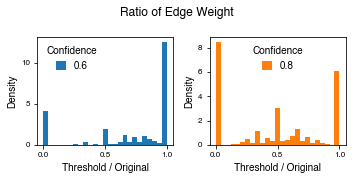

In [182]:
# # H, xbins, ybins = np.histogram2d(u_edge_df["weight_0.0"], u_edge_df["weight_0.6"], bins=100)
# plt.hist2d(u_edge_df["weight_0.0"]+1, u_edge_df["weight_0.6"]+1,
#            bins=100,
#            cmap=ListedColormap(cc.blues), cmin=1,
#            norm=matplotlib.colors.LogNorm())
# plt.xscale("log")
# plt.yscale("log")

plt.figure(figsize=(5,2.5), tight_layout="tight")
plt.suptitle("Ratio of Edge Weight", fontsize=12)
for i, (thresh, color) in enumerate(zip(["0.6", "0.8"], plt.rcParams["axes.prop_cycle"].by_key()["color"])):
    plt.subplot(1,2,i+1)
    plt.hist(u_master_edge_df[f"weight_{thresh}"] / u_master_edge_df["weight_0.0"],
             bins=np.linspace(0,1,26), density=True,
             color=color,
             label=thresh)
    plt.xlabel("Threshold / Original", fontsize=10)
    plt.ylabel("Density", fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(frameon=False, handlelength=1, handleheight=1, title="Confidence", fontsize=10)
    
for ext in ["png", "pdf"]:
    print("Saving", ext)
    plt.savefig(os.path.join(figure_dir, "Supplement", f"threshold_edge_ratios.{ext}"), bbox_inches="tight")

In [106]:
chi, thresh = "0.0", "0.6"
V,E = reduced_graph(master_node_df, u_master_edge_df, f"{chi}_{thresh}",
                    suffixes=["pre", "post"],
                    u_col="pre", v_col="post",
                    weight_col=f"weight_{thresh}")

In [107]:
display(V,E)

,n_nodes,n_edges,weight_0.6,possible_edges,edge_density,weighted_density
0.0_0.6,,,,,,
1,5770,418241,1619415,16643565,0.025129,0.097300
2,2395,324503,1282481,2866815,0.113193,0.447354
3,3072,340706,1298669,4717056,0.072229,0.275313
4,3084,405044,1589566,4753986,0.085201,0.334365
5,2319,294531,1472358,2687721,0.109584,0.547809
6,4075,51265,672251,8300775,0.006176,0.080987
7,931,363732,1714272,432915,0.840193,3.959835
8,87,607,2033,3741,0.162256,0.543438


,0.0_0.6pre,0.0_0.6post,n_edges,weight_0.6,n_cluster1,n_cluster2,possible_edges,edge_density,weighted_density
0,1,1,418241,1619415,5770,5770,16643565,0.025129,0.097300
1,1,2,46755,111834,5770,2395,13819150,0.003383,0.008093
8,2,2,324503,1282481,2395,2395,2866815,0.113193,0.447354
2,1,3,128943,383331,5770,3072,17725440,0.007274,0.021626
9,2,3,95394,232465,2395,3072,7357440,0.012966,0.031596
15,3,3,340706,1298669,3072,3072,4717056,0.072229,0.275313
3,1,4,115260,278562,5770,3084,17794680,0.006477,0.015654
10,2,4,36564,75588,2395,3084,7386180,0.004950,0.010234
16,3,4,36692,88451,3072,3084,9474048,0.003873,0.009336
21,4,4,405044,1589566,3084,3084,4753986,0.085201,0.334365


In [191]:
data_space_radius = 1.5
legend_width = 0.4

thickness_legend_x_start = -1.15
cross_legend_y = -1.35
loop_legend_y = -1.55

diam_legend_x_end = 1.0

edge_weight = "weighted_density"
pretty_print = {"weighted_density": "Weighted Density"}

loop_color = "gray"

roi00 = pd.DataFrame.from_dict(cluster_roi_map["0.0"], orient="index", columns=["ROIs"])
# roi00["x"] = 2
# roi00["y"] = np.linspace(-1, 1, 8)[::-1]
roi00["x"] = 100
roi00["y"] = 100  # way far away from the picture
roi00["color"] = [color_mapper(c, "0.0") for c in roi00.index]

subgraphs = {"0.0": [2, 7]}

custom00order = [2, 3, 4, 5, 7, 1, 6, 8]
def custom_sort(a):
    """A custom order for the clusters at chi = 0.0"""
    return [custom00order.index(x) for x in a]

legend_cs = {"0.0":  [1.1e-5, 0.1],
             "0.05": [3.9e-6, 0.2],
             "0.1":  [2.9e-6, 0.9],
             "0.25": [4.1e-6, 4.1]}
legend_ls = {"0.0":  [1.2e-1, 2.0],
             "0.05": [1.3e-1, 21.0],
             "0.1":  [1.8e-1, 28.0],
             "0.25": [2.7e-1, 154.0]}
legend_rs = {"0.0":  [100, 5700],
             "0.05": [5, 4300],
             "0.1":  [5, 3000],
             "0.25": [5, 1900]}


# thresh="0.6"
fs = []
for f_idx, chi in enumerate(reneel_params[:2]):

    chi_fs = []
    for thresh in map(str, [0.6, 0.8]):
        log_msg("Synapse Confidence Threshold:", thresh)
        col = f"{chi}_{thresh}"
        rn, E = reduced_graph(master_node_df, u_master_edge_df[u_master_edge_df[f"weight_{thresh}"] > 0], f"{chi}_{thresh}",
                        suffixes=["pre", "post"],
                        u_col="pre", v_col="post",
                        weight_col=f"weight_{thresh}")

        rn.rename(columns={f"weight_{thresh}":"total_weight"}, inplace=True)
        E.rename(columns={f"{chi}_{thresh}pre": f"{chi}_{thresh}_1",
                      f"{chi}_{thresh}post": f"{chi}_{thresh}_2",
                      f"weight_{thresh}": "total_weight"},
             inplace=True)

        rn["color"] = [color_mapper(c, chi) for c in rn.index]
        original_n = rn.shape[0]

        cluster_threshold = 5
        frn = rn[rn.n_nodes >= cluster_threshold]
    #     frn = frn.merge(roi00, left_index=True, right_index=True)
        fre = E[(E.n_cluster1 >= cluster_threshold) & (E.n_cluster2 >= cluster_threshold)]
        n_nodes = frn.shape[0]

        if chi != "0.0":
            plurality = master_node_df.value_counts([col, f"0.0_{thresh}"]).reset_index().groupby(col).agg({f"0.0_{thresh}":"first"})
            frn = frn.merge(plurality, left_index=True, right_index=True, how="left")
            frn["color"] = [color_mapper(c, chi) for c in frn[f"0.0_{thresh}"]]
        # display(frn)
        print("Cluster threshold =", cluster_threshold)
        print(original_n,"nodes at chi =",chi)
        print(n_nodes, "shown")
        print(f"{frn.n_nodes.sum()} Neurons ({frn.n_nodes.sum() / HB_node_df.shape[0]:.2%}) included")

        draw_kws = dict(edge_start_col=f"{col}_1", edge_end_col=f"{col}_2",
                        edge_weight_col=edge_weight,
                        scale_nodes_by="n_nodes", node_scale_mode="linear",
                        scale_loops_by=edge_weight, # by specifying this, it should scale loops separately from edges
                        node_fill_mode="custom", node_line_width=0,
                        loop_default_color=loop_color,)

        if float(chi) > 0:
            shift_cluster = 1
            num_shift = np.count_nonzero(frn[f"0.0_{thresh}"] == shift_cluster)
            dtheta = 2 * np.pi / n_nodes
            draw_kws["circle_layout_kwargs"] = {"theta_offset": -dtheta * (num_shift - 1) / 2 }
            frn = frn.merge(roi00["ROIs"], left_on=f"0.0_{thresh}", right_index=True)
        else:
            frn = frn.merge(roi00["ROIs"], left_index=True, right_index=True)
        layout = "circle"


        if chi == "0.0":
            draw_kws["loop_r"] = 0.17
        g = draw_graph(frn.sort_values(f"0.0_{thresh}"), fre,
                       layout=layout,
                       edge_draw_function=lambda p,q: poincare_geodesic([0,0], 1.0, p, q, k=5),
                       loop_draw_function=lambda p,q: outer_loop_circle([0,0], p, 2*np.pi/n_nodes/4, k=5),
                       **draw_kws,)




        f = figure(title=None, #"Reduced graph, chi = "+chi,
                   x_range=Range1d(-data_space_radius, data_space_radius, 
                                   bounds=(-data_space_radius, data_space_radius)),
                   y_range=Range1d(-data_space_radius - 0.25, data_space_radius,
                                   bounds=((-data_space_radius - 0.25, data_space_radius))),
                   width=600, height=650,
                   border_fill_color=None,
                   outline_line_color=None,
                   background_fill_color=None,)
        f.renderers.append(g)
        f.add_tools(TapTool(), HoverTool(tooltips={"Cluster":"@index", "Nodes":"@n_nodes", "Brain Regions":"@ROIs"}))



        w_min = g.edge_renderer.data_source.data["width"].min()
        w_max = g.edge_renderer.data_source.data["width"].max()
        # Add the edge thickness legend
        cross_weights = fre[fre[col+"_1"] != fre[col+"_2"]][edge_weight]
        c_min, c_max = cross_weights.min(), cross_weights.max()


        # th_min = g.edge_renderer.data_source.data[edge_weight].min()
        # th_max = g.edge_renderer.data_source.data[edge_weight].max()
        edf = g.edge_renderer.data_source.to_df()
        cross = edf[edf.color == "black"]
        add_thickness_legend(f,
                             thickness_legend_x_start, thickness_legend_x_start + legend_width,
                             cross_legend_y, cross_legend_y,
                             cross.width.min(), cross.width.max(),
    #                          w_min, w_max,
                             "", #f"{cross_weights.min():0.2e}",
                             "", #f"{cross_weights.max():0.2f}",
                             y_offset=7,
                             multiline_params={"line_color": "black"},
                             label_params={"text_font_size": "10pt"})
        print(f"Cross Weights: {cross_weights.min():0.2e}, {cross_weights.max():0.2f}")

        # add the self-loop thickness legend
        loop_weights = fre[fre[col+"_1"] == fre[col+"_2"]][edge_weight]
        l_min, l_max = loop_weights.min(), loop_weights.max()
        loops = edf[edf.color=="gray"]
        add_thickness_legend(f,
                             thickness_legend_x_start, thickness_legend_x_start + legend_width,
                             loop_legend_y, loop_legend_y,
                             loops.width.min(), loops.width.max(),
                             "", #f"{loop_weights.min():0.2e}",
                             "", #f"{loop_weights.max():0.2f}",
                             y_offset=7,
                             multiline_params={"line_color": loop_color},
                             label_params={"text_font_size": "10pt", "text_color": loop_color})
        print(f"Loop weights: {loop_weights.min():0.2e}, {loop_weights.max():0.2f}")

    #     f.add_layout(Label(text=pretty_print.get(edge_weight, edge_weight),
    #                        x=-1.35, y=-1.15, text_font_size="12pt"))

        # add the node size legend
        radii = g.node_renderer.data_source.data["radius"]
        sizes = g.node_renderer.data_source.data["n_nodes"]
        add_radius_legend(f,
                          diam_legend_x_end - legend_width, diam_legend_x_end,
                          loop_legend_y, loop_legend_y,
                          radii.min(), radii.max(),
#                           str(sizes.min()), str(sizes.max()),
                          "", "",
                          y_offset=-15,
                          label_params={"text_font_size": "10pt"})
        print(f"Radius mapping: {sizes.min()}, {sizes.max()}")
    #     f.add_layout(Label(text="Neurons",
    #                        x=0.95, y=-1.4, y_offset=-15,
    #                        text_align="center", text_font_size="12pt"))



        f.axis.visible = False
        f.grid.visible = False
    #     show(f)
        chi_fs.append(f)
    fs.append(chi_fs)
show(gridplot(fs))
# save(gridplot(fs, ncols=2), filename=os.path.join(figure_dir, "Reduced_graphs.html"), title="Reduced Graphs for chi up to 0.25")

2022 11 11 20:41:36  Synapse Confidence Threshold: 0.6
Cluster threshold = 5
8 nodes at chi = 0.0
8 shown
21733 Neurons (100.00%) included
Cross Weights: 6.17e-05, 0.05
Loop weights: 9.73e-02, 1.55
Radius mapping: 87, 5770
2022 11 11 20:41:48  Synapse Confidence Threshold: 0.8
Cluster threshold = 5
8 nodes at chi = 0.0
8 shown
21733 Neurons (100.00%) included
Cross Weights: 1.20e-05, 0.03
Loop weights: 7.06e-02, 1.02
Radius mapping: 86, 5610
2022 11 11 20:41:54  Synapse Confidence Threshold: 0.6
Cluster threshold = 5
69 nodes at chi = 0.05
23 shown
21665 Neurons (99.69%) included
Cross Weights: 3.68e-06, 0.14
Loop weights: 1.34e-01, 17.33
Radius mapping: 5, 3526
2022 11 11 20:42:07  Synapse Confidence Threshold: 0.8
Cluster threshold = 5
57 nodes at chi = 0.05
21 shown
21674 Neurons (99.73%) included
Cross Weights: 3.70e-06, 0.09
Loop weights: 6.93e-02, 13.87
Radius mapping: 6, 4296


In [48]:
# Partition the synapses by ROI and bodyId. 
# recompute_adj = False
recompute_adj = not os.path.isfile(os.path.join(analysis_dir, "neuron-roi-synapses.csv"))

if recompute_adj:
    log_msg("Computing full neuron-ROI adjacency list, including non-leaf ROIs. This could take a while...")
    time_start = time.time()
    neuron_roi_adj = get_roi_adjacency(HB_node_df, leaf_only=False)
    time_end = time.time()
    log_msg(f"Done! Took {time_end - time_start:.2f}s")
    log_msg("Computing total synapses per neuron")
    neuron_roi_adj["total_synapses"] = neuron_roi_adj["pre"] + neuron_roi_adj["post"]
    log_msg("Writing csv file")
    neuron_roi_adj.to_csv(os.path.join(analysis_dir, "neuron-roi-synapses.csv"), index=False)
else:
    log_msg("Loading the neuron-ROI synapse list from file")
    neuron_roi_adj = pd.read_csv(os.path.join(analysis_dir, "neuron-roi-synapses.csv"))
    log_msg("Done!")
#     log_msg("Not recomputing the whole neuron-ROI adjacency list. Just updating roi names.")




# neuron_roi_adj
nra_leaves = neuron_roi_adj[neuron_roi_adj.roi.isin(roi_leaves.index)]
nra_leaves



2022 11 09 14:00:59  Loading the neuron-ROI synapse list from file
2022 11 09 14:01:00  Done!


,roi,pre,post,downstream,upstream,bodyId,0.0,0.05,0.1,0.25,0.5,0.75,1.0,parent,parent_2,parent_3,parent_4,primary,total_synapses
1,SLP(R),17,18,207,18,200326126,1,1,1,1,1,1,1,SNP(R),hemibrain,hemibrain,hemibrain,True,35
2,dACA(R),2,9,19,9,200326126,1,1,1,1,1,1,1,MB(+ACA)(R),hemibrain,hemibrain,hemibrain,False,11
5,SCL(R),152,341,1895,341,200326126,1,1,1,1,1,1,1,INP,hemibrain,hemibrain,hemibrain,True,493
6,LH(R),1,7,10,7,200326126,1,1,1,1,1,1,1,hemibrain,hemibrain,hemibrain,hemibrain,True,8
8,PLP(R),97,414,1115,414,200326126,1,1,1,1,1,1,1,VLNP(R),hemibrain,hemibrain,hemibrain,True,511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222532,LAL(-GA)(R),192,80,1526,80,7112622044,3,3,8,14,85,722,2853,LAL(R),LX(R),hemibrain,hemibrain,False,272
222534,VES(L),41,127,281,127,7112622044,3,3,8,14,85,722,2853,VMNP,hemibrain,hemibrain,hemibrain,True,168
222535,VES(R),15,4,137,4,7112622044,3,3,8,14,85,722,2853,VMNP,hemibrain,hemibrain,hemibrain,True,19
222538,g5(R),0,1,0,1,7112622044,3,3,8,14,85,722,2853,gL(R),MB(R),MB(+ACA)(R),hemibrain,False,1


In [47]:
nra_leaves

,roi,pre,post,downstream,upstream,bodyId,0.0,0.05,0.1,0.25,0.5,0.75,1.0,parent,parent_2,parent_3,parent_4,primary,total_synapses
1,SLP(R),17,18,207,18,200326126,1,1,1,1,1,1,1,SNP(R),hemibrain,hemibrain,hemibrain,True,35
2,dACA(R),2,9,19,9,200326126,1,1,1,1,1,1,1,MB(+ACA)(R),hemibrain,hemibrain,hemibrain,False,11
5,SCL(R),152,341,1895,341,200326126,1,1,1,1,1,1,1,INP,hemibrain,hemibrain,hemibrain,True,493
6,LH(R),1,7,10,7,200326126,1,1,1,1,1,1,1,hemibrain,hemibrain,hemibrain,hemibrain,True,8
8,PLP(R),97,414,1115,414,200326126,1,1,1,1,1,1,1,VLNP(R),hemibrain,hemibrain,hemibrain,True,511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222532,LAL(-GA)(R),192,80,1526,80,7112622044,3,3,8,14,85,722,2853,LAL(R),LX(R),hemibrain,hemibrain,False,272
222534,VES(L),41,127,281,127,7112622044,3,3,8,14,85,722,2853,VMNP,hemibrain,hemibrain,hemibrain,True,168
222535,VES(R),15,4,137,4,7112622044,3,3,8,14,85,722,2853,VMNP,hemibrain,hemibrain,hemibrain,True,19
222538,g5(R),0,1,0,1,7112622044,3,3,8,14,85,722,2853,gL(R),MB(R),MB(+ACA)(R),hemibrain,False,1


# Cell Body Fiber graphs
For a comparison to clonal units in the brain, we look at CBFs


Including only edges with weight at least 0
There are 15681 total CBF group connections of a possible 18336, for a density of 85.52%
Including only edges with weight at least 5
There are 11765 total CBF group connections of a possible 18336, for a density of 64.16%


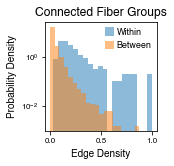

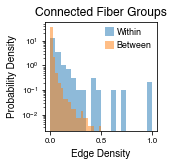

In [172]:
hist_kws = dict(density=True, bins=20, alpha=0.5)
tick_kws = dict(fontsize=8)
label_kws = dict(fontsize=10)
title_kws = dict(fontsize=12)

# min_weight = 0
for min_weight in [0, 5]:
    V,E = reduced_graph(HB_node_df, u_edge_df[u_edge_df.total_weight >= min_weight], "cellBodyFiber")
#     display(V,E)
    n, m = V.shape[0], E.shape[0]
    rho = 2 * m / (n * (n - 1))
    print(f"Including only edges with weight at least {min_weight}")
    print(f"There are {m} total CBF group connections of a possible {n * (n-1) // 2}, for a density of {rho:4.2%}")



    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["font.sans-serif"] = "Helvetica"

    

    plt.figure(figsize=(2,2))
    plt.hist(V.edge_density,
             label="Within",
             **hist_kws)
    plt.hist(E[E.cellBodyFiber_u != E.cellBodyFiber_v].edge_density,
             label="Between",
             **hist_kws)
    plt.legend(frameon=False, fontsize=9, borderpad=0.1,
               handlelength=1, handleheight=1, handletextpad=0.3)
    plt.yscale("log")
    plt.title("Connected Fiber Groups", **title_kws)
    plt.xticks(**tick_kws)
    plt.yticks(**tick_kws)
    plt.xlabel("Edge Density", **label_kws)
    plt.ylabel("Probability Density", **label_kws)

    for ext in ["png","pdf"]:
        plt.savefig(os.path.join(figure_dir, "Supplement", f"CBF-connections-min-{min_weight}.{ext}"),
                    bbox_inches="tight")

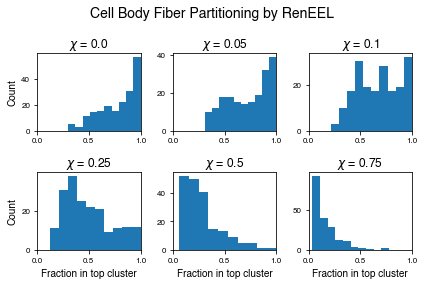

In [170]:
plt.figure(figsize=(6,4), tight_layout="tight")
plt.suptitle("Cell Body Fiber Partitioning by RenEEL", size=14)
for i, chi in enumerate(reneel_params[:6]):
    j = joint_marginal(HB_node_df, chi, "cellBodyFiber", True)
#     plt.figure(figsize=(2,2))
    plt.subplot(2,3,i+1)
    plt.hist(j.groupby("cellBodyFiber").agg({"cellBodyFiber_fraction": "max"})["cellBodyFiber_fraction"],
             bins=10)
    plt.title(f"$\chi$ = {chi}", **title_kws)
    if i >= 3:
        plt.xlabel("Fraction in top cluster", **label_kws)
    if i % 3 == 0:
        plt.ylabel("Count", **label_kws)
    plt.xlim(0,1)
    plt.xticks(**tick_kws)
    plt.yticks(**tick_kws)

for ext in ["png","pdf"]:
    plt.savefig(os.path.join(figure_dir, "Supplement", f"CBF-vs-RenEEL.{ext}"), bbox_inches="tight")